In [ ]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [ ]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [ ]:
## Считываем данные
data = pd.read_csv("drive/MyDrive/ML/mlcourse.ai/A5/credit_scoring_sample.csv")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [ ]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [ ]:
data.columns

Index(['SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
       'DebtRatio', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome',
       'NumberOfDependents'],
      dtype='object')

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

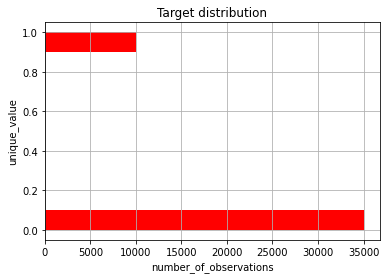

In [ ]:
## Посмотрим на распределение классов в зависимой переменной

ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [ ]:
data.shape

(45063, 8)

In [ ]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [ ]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [ ]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [ ]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    print(indices)
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
age = table[table['SeriousDlqin2yrs'] == True]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
age_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(age, 1000)]

#  выводим интервальную оценку среднего
print("Age:  mean interval",  stat_intervals(age_mean_scores, 0.1))


[[2732 9845 3264 ... 4709 7923 2308]
 [ 934  966 3955 ... 8063 2244 1571]
 [6075 5548 1780 ... 3611 2585 9893]
 ...
 [4494 4771 7932 ... 1697 6634 3958]
 [2302 3763 4086 ... 5128 9104 8992]
 [2434  263 7049 ... 9903 6269 8803]]
Age:  mean interval [45.71379414 46.12700479]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [ ]:
gs = GridSearchCV(lr, parameters, scoring='roc_auc', cv=skf)
gs.fit(X,y)
gs.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
gs.cv_results_['std_test_score'][1]

0.008137559189742445

In [ ]:
gs.best_score_

0.8089120626797153

In [ ]:
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [ ]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.1142637528306527


In [ ]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X,y)
lr.coef_

array([[-1.36555119e-02,  4.46831824e-01, -6.49409539e-06,
         3.90380367e-01,  2.16038059e-01, -1.14780890e-05,
         1.91725855e-01]])

In [ ]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390380
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [ ]:
np.exp(lr.coef_[0][0]*20)

0.7610088905341168

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5) 
skf.get_n_splits()

5

In [ ]:
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - gs.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.6min finished


0.026805420792832102


In [ ]:
independent_columns_names[np.argmin(rf_grid_search.best_estimator_.feature_importances_)]

'NumberOfDependents'

In [ ]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': rf_grid_search.best_estimator_.feature_importances_}).sort_values(by='coef', ascending=False)

,feat,coef
3,NumberOfTimes90DaysLate,0.314934
1,NumberOfTime30-59DaysPastDueNotWorse,0.295335
4,NumberOfTime60-89DaysPastDueNotWorse,0.128935
0,age,0.100434
2,DebtRatio,0.089620
5,MonthlyIncome,0.059142
6,NumberOfDependents,0.011600


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, n_jobs=-1, random_state=42)
r_grid_search = RandomizedSearchCV(bg, parameters, n_jobs=-1, 
                                   scoring='roc_auc', cv=skf, n_iter=20, random_state=1,
                                   verbose=True)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.4min finished


In [ ]:
r_grid_search.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(C=100,
                                                    class_weight='balanced',
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=2,
                  max_samples=0.9, n_estimators=100, n_jobs=-1

In [ ]:
r_grid_search.best_score_

0.807140803304167